In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

In [4]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [5]:
print(df_train.describe())

                 id    person_age  person_income  person_emp_length  \
count  58645.000000  58645.000000   5.864500e+04       58645.000000   
mean   29322.000000     27.550857   6.404617e+04           4.701015   
std    16929.497605      6.033216   3.793111e+04           3.959784   
min        0.000000     20.000000   4.200000e+03           0.000000   
25%    14661.000000     23.000000   4.200000e+04           2.000000   
50%    29322.000000     26.000000   5.800000e+04           4.000000   
75%    43983.000000     30.000000   7.560000e+04           7.000000   
max    58644.000000    123.000000   1.900000e+06         123.000000   

          loan_amnt  loan_int_rate  loan_percent_income  \
count  58645.000000   58645.000000         58645.000000   
mean    9217.556518      10.677874             0.159238   
std     5563.807384       3.034697             0.091692   
min      500.000000       5.420000             0.000000   
25%     5000.000000       7.880000             0.090000   
50%   

# Explority Data Analysis(EDA)

In [6]:
print(df_train.isnull().sum())

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


## Plot Distribution 

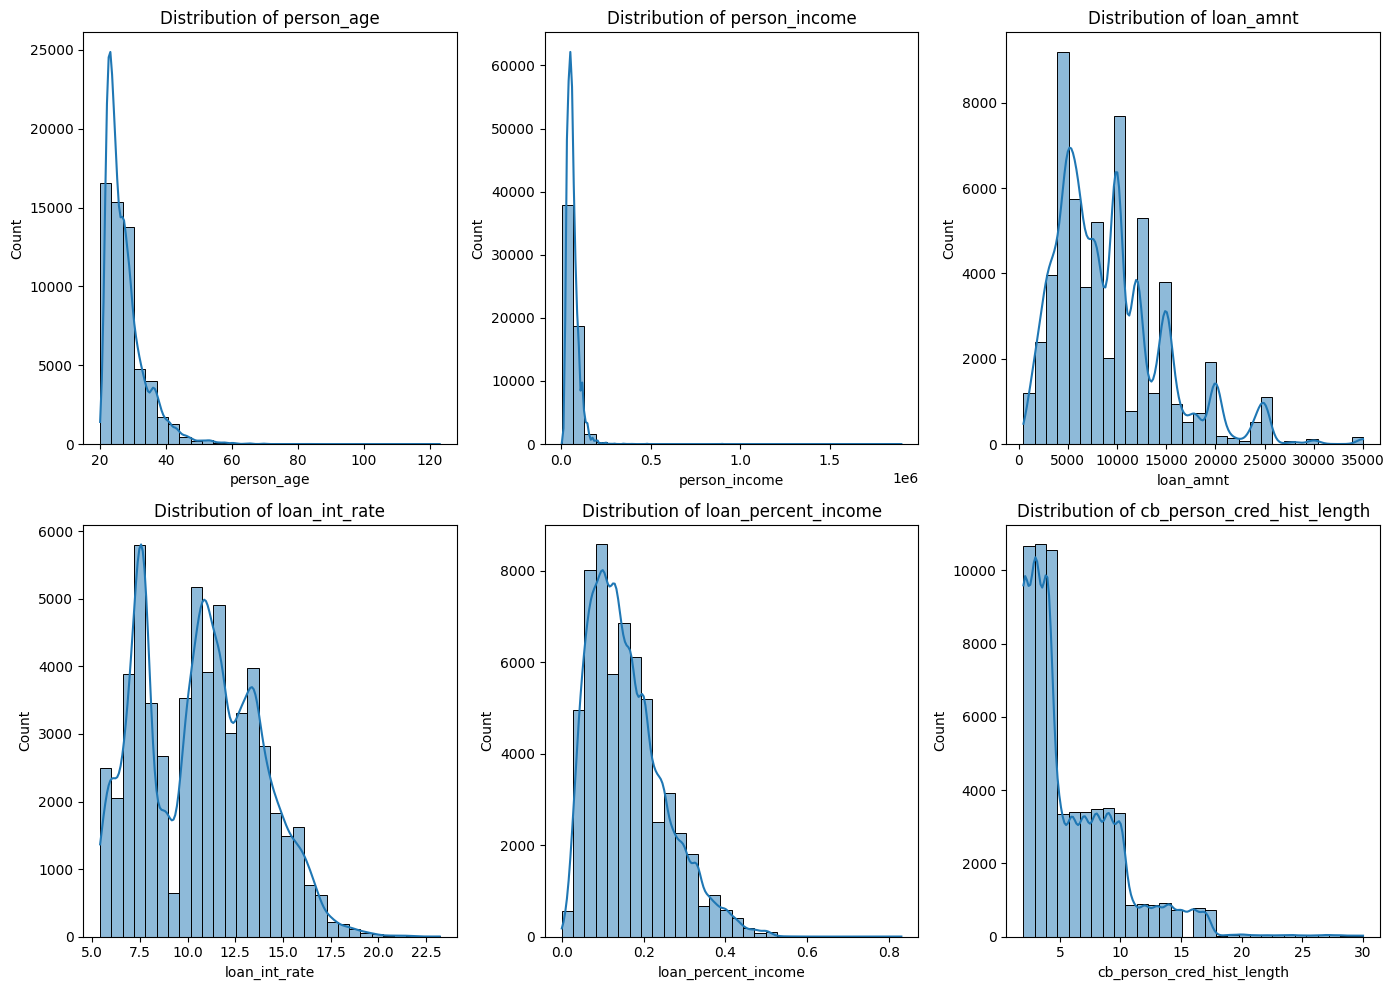

In [7]:
num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
plt.figure(figsize=(14,10))

for i, col in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

person_home_ownership value counts:
 person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64
loan_intent value counts:
 loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64
loan_grade value counts:
 loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64
cb_person_default_on_file value counts:
 cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64


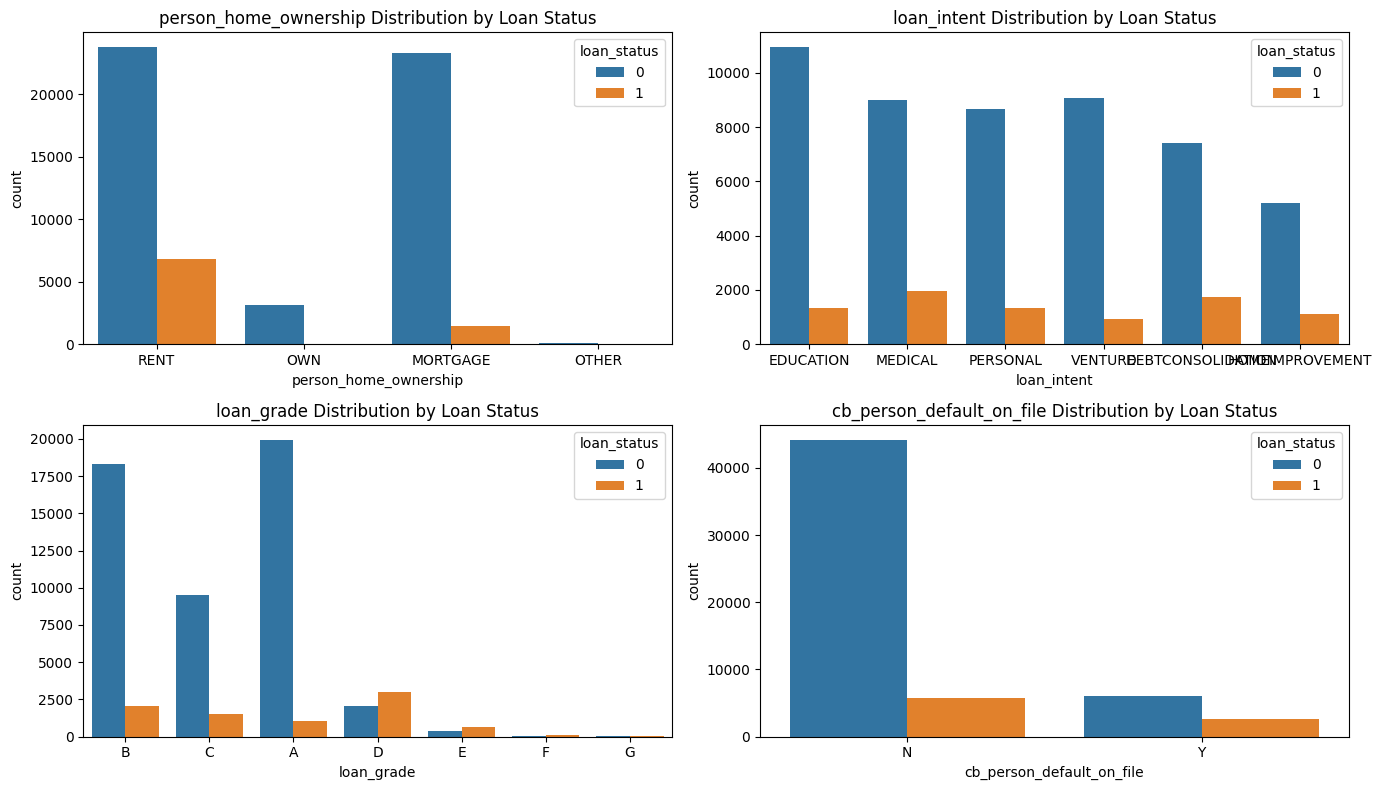

In [8]:
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for col in cat_features:
    print(f"{col} value counts:\n", df_train[col].value_counts())

plt.figure(figsize=(14,8))
for i, col in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df_train, x=col, hue='loan_status')
    plt.title(f'{col} Distribution by Loan Status')
plt.tight_layout()
plt.show()

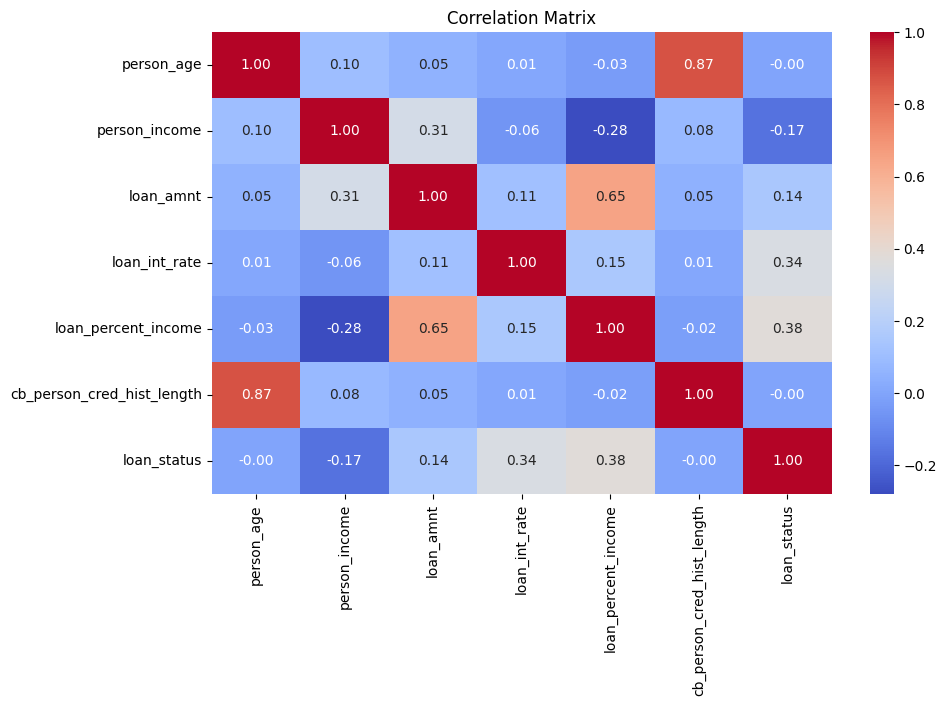

In [9]:
plt.figure(figsize=(10,6))
corr_matrix = df_train[num_features + ['loan_status']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing

In [10]:
X = df_train.drop(columns=['loan_status', 'id'])
y = df_train['loan_status']

In [11]:
numeric_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)


# Building the Artificial Neural Network (ANN)

In [13]:
model = Sequential()

#input layer
model.add(Dense(units=128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dropout(0.3))

#hidden layers
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.3))

#output layer
model.add(Dense(units=1, activation="sigmoid"))

#compiling
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])


Epoch 1/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8834 - loss: 0.2935 - val_accuracy: 0.9321 - val_loss: 0.1980
Epoch 2/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9337 - loss: 0.2039 - val_accuracy: 0.9393 - val_loss: 0.1874
Epoch 3/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9344 - loss: 0.2065 - val_accuracy: 0.9399 - val_loss: 0.1852
Epoch 4/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9357 - loss: 0.1984 - val_accuracy: 0.9378 - val_loss: 0.1887
Epoch 5/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9379 - loss: 0.1959 - val_accuracy: 0.9383 - val_loss: 0.1886
Epoch 6/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9379 - loss: 0.1963 - val_accuracy: 0.9425 - val_loss: 0.1865
Epoch 7/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9376 - loss: 0.1929 - val_accuracy: 0.9400 - val_loss: 0.1865
Epoch 8/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9399 - loss: 0.1908 - 

# Training the Model

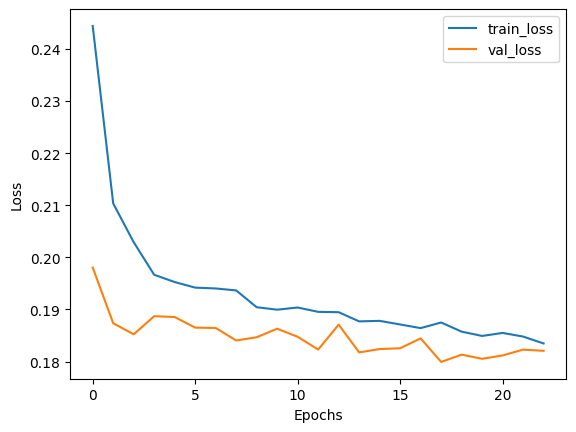

In [15]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation on Validation Data

In [16]:
y_val_pred = model.predict(X_val)
y_val_pred_class = (y_val_pred > 0.5).astype(int)


val_accuracy = accuracy_score(y_val, y_val_pred_class)
val_roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation ROC-AUC Score: {val_roc_auc:.4f}")

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Accuracy: 0.9421
Validation ROC-AUC Score: 0.9316


# Predictions on Test Data and Submission

In [17]:
X_test = df_test.drop(columns=['id'])
X_test_preprocessed = preprocessor.transform(X_test)

test_predictions = model.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_status': test_predictions.flatten()
})

submission.to_csv('submission.csv', index=False)

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
